In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 6.7MB/s 
     |████████████████████████████████| 1.1MB 20.9MB/s 
     |████████████████████████████████| 3.0MB 32.6MB/s 
     |████████████████████████████████| 890kB 40.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=eb1b5e3dd5a376a34d8edadc87632b2df39840d0ea1223dcc1aaf738e9090d9f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
pip install docx2txt

  Created wheel for docx2txt: filename=docx2txt-0.8-cp36-none-any.whl size=3965 sha256=111bea7fe35ff238336bb50252df7239763763018d8333d3fb65983cea29e989
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt


In [ ]:
pip install rouge

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib
from pprint import pprint
import matplotlib.pyplot as plt
from google.colab import drive
import docx2txt
from rouge import Rouge 
import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Funcoes

In [ ]:
def content_sentences(body):
        sentences = tokenize.sent_tokenize(body, language='portuguese')
        return [c for c in sentences]

def tokenize_input(text):
        tokenized_text = tokenizer.tokenize(text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        return torch.tensor([indexed_tokens])

def extract_embeddings(text):
        tokens_tensor = tokenize_input(text)
        hidden_states, pooled = model(tokens_tensor)[-2:]
        return pooled

##Classes

In [ ]:
class ClusterFeatures(object):
    def __init__(self, features, algorithm='kmeans', pca_k=2):
        if pca_k:
            self.features = PCA(n_components=pca_k).fit_transform(features)
        else:
            self.features = features
        self.algorithm = algorithm
        self.pca_k = pca_k

    def __get_model(self, k):
        if self.algorithm == 'gmm':
            return GaussianMixture(n_components=k)
        if self.algorithm == 'affinity':
            return AffinityPropagation()
        return KMeans(n_clusters=k)

    def __get_centroids(self, model):
        if self.algorithm == 'gmm':
            return model.means_
        return model.cluster_centers_

    def __find_closest_args(self, centroids):
        centroid_min = 1e7
        cur_arg = -1
        args = {}
        used_idx = []
        for j, centroid in enumerate(centroids):
            for i, feature in enumerate(self.features):
                value = np.sum(np.abs(feature - centroid))
                if value < centroid_min and i not in used_idx:
                    cur_arg = i
                    centroid_min= value
            used_idx.append(cur_arg)
            args[j] = cur_arg
            centroid_min = 1e7
            cur_arg = -1
        return args

    def cluster(self, ratio=0.1):
        k = 1 if ratio * len(self.features) < 1 else int(len(self.features) * ratio)
        model = self.__get_model(k).fit(self.features)
        centroids = self.__get_centroids(model)
        cluster_args = self.__find_closest_args(centroids)
        sorted_values = sorted(cluster_args.values())
        return sorted_values

    def create_plots(self, k=4, plot_location='./cool_model.png', title = ''):
        if self.pca_k != 2:
            raise RuntimeError("Must be dimension of 2")

        model = self.__get_model(k)
        model.fit(self.features)
        y = model.predict(self.features)
        plt.title(title)
        plt.scatter(self.features[:, 0], self.features[:, 1], c=y, s=50, cmap='viridis')
        centers = model.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
        plt.savefig(plot_location)

##Aplicacao

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
body = docx2txt.process("/content/drive/My Drive/IC/textos_sumarios/textos/0texto_completo.docx")

In [ ]:
initial_sentences = content_sentences(body)

In [ ]:
model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')

In [ ]:
vector_size = 1024

train_vec = np.zeros((len(initial_sentences), vector_size))

for i, t in tqdm(enumerate(initial_sentences)):
            train_vec[i] = extract_embeddings(t).data.numpy()

232it [01:50,  2.10it/s]


In [ ]:
ratio = 0.2

hidden_args = ClusterFeatures(train_vec).cluster(ratio)

if hidden_args[0] != 0:
            hidden_args.insert(0,0)

resultado = [initial_sentences[j] for j in hidden_args]

pprint("".join(resultado))

('A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): 1.218.875.2.33, caput, '
 'combinado com o art.40, I, da Lei 11.343/2006 (e-STJ Fls.Na dosimetria da '
 'pena, foi aplicada a causa de diminuição de pena estabelecida no § 4º do '
 'art.DOSIMETRIA DAS PENAS.PENA-BASE.Configuração do concurso de pessoas, não '
 'havendo sustentação para a tese de erro de tipo.42 da Lei nº 11 '
 '.343/06.Penas do corréu corretamente fixadas.Os artigos 33, § 40, e 44 da '
 'Lei no 11 .343/06 vedaram a substituição da pena privativa de liberdade em '
 'restritiva de direitos, nos crimes de tráfico de entorpecentes.8.Consta dos '
 'autos que os pacientes foram condenados às penas, respectivamente, 03 anos e '
 '06 meses de reclusão e 10 anos e 06 meses de reclusão, pela prática do '
 'delito previsto no art.30, c/c art.11.343/06.Intime-se.” (Evento 3, '
 'fl.INEXISTÊNCIA DE ILEGALIDADE.Precedentes: HC 109.956/PR, Rel.Rosa Weber, '
 'DJe de 6.9.2012, dentre outros.Nessa toada, tem-se analisado as questões '
 's

In [ ]:
sumario = docx2txt.process("/content/drive/My Drive/IC/textos_sumarios/sumarios/0sumario.docx")

pprint(sumario)

('“Segundo informações contidas nos autos, em 18/03/2010, HERLAN CAUMOL OLIVA '
 'e SILVA PANIAGUA CUANI foram denunciados pelo Ministério Público Federal '
 '(MPF) como incursos nas sanções do art. 33, caput, combinado com o art. 40, '
 'inciso I, ambos da Lei 11.343/2006, e com o art. 29 do Código Penal (CP), '
 'por terem sido, supostamente, no dia 18/02/2010, na cidade de Porto '
 'Velho/RO, presos em flagrante, no Km 760 da estrada BR 364, transportando '
 '1.497 g (um mil e quatrocentos e noventa e sete gramas) da substância '
 'entorpecente “cocaína”, oriunda da Bolívia (eSTJ Fls. 09-11).  Em 22.3.2013, '
 'indeferi a liminar, requisitei informações e determinei que se colhesse a '
 'manifestação da Procuradoria-Geral da República (Evento 15). HC 117044 9. '
 'Conforme relatado, pretende a Impetrante a fixação de regime inicial mais '
 'benéfico de cumprimento da pena privativa de liberdade imposta ao Paciente '
 'pela prática do delito de tráfico de drogas. Pede, ainda, lhe sej

In [ ]:
rouge = Rouge()

scores = rouge.get_scores("".join(resultado), sumario)

pprint(scores)

[{'rouge-1': {'f': 0.314176241276497,
              'p': 0.21494102228047182,
              'r': 0.5836298932384342},
  'rouge-2': {'f': 0.1497120882003825,
              'p': 0.10236220472440945,
              'r': 0.2785714285714286},
  'rouge-l': {'f': 0.23648648221517765,
              'p': 0.17114914425427874,
              'r': 0.3825136612021858}}]


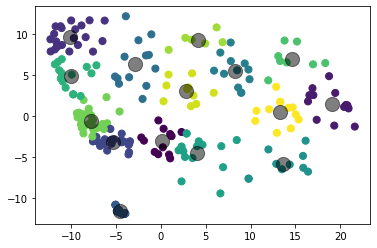

In [ ]:
ClusterFeatures(train_vec).create_plots(15)